In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

In [2]:
# Indicators which are expected to indicate urbanization if their values are high
URBANIZATION_INDICATORS = [
    'Air transport, freight (million ton-km)',
    'Air transport, passengers carried',
    'Annual freshwater withdrawals, industry (% of total freshwater withdrawal)',
    'CO2 emissions (metric tons per capita)',
    'Commercial bank branches (per 100,000 adults)',
    'Employment in industry (% of total employment) (modeled ILO estimate)',
    'Employment in services (% of total employment) (modeled ILO estimate)',
    'Industry (including construction), value added per worker (constant 2010 US$)',
    'Manufacturing, value added (% of GDP)',
    'Medium and high-tech industry (% manufacturing value added)',
    'Railways, goods transported (million ton-km)',
    'Railways, passengers carried (million passenger-km)',
    'Urban population (% of total)',
    
    # Other indicators that could be used (internet access tends to be better in densely populated areas, more universities in
    # cities)
    'Individuals using the Internet (% of population)',
    "Educational attainment, competed at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",
    "Educational attainment, competed at least Master's or equivalent, population 25+, total (%) (cumulative)",
]

# Indiccators which are expected to indicate urbanization if their values are low
ANTI_URBANIZATION_INDICATORS = [
    'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)',
    'Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)',
    'Employment in agriculture (% of total employment) (modeled ILO estimate)',
    'Forest area (% of land area)',
]

In [3]:
df = pd.read_csv('tmp/developing_countries.csv')
df.head()


,Country,Country code,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,...,Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Forest area (% of land area),Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)","Manufacturing, value added (% of GDP)",Medium and high-tech industry (% manufacturing value added),"Railways, goods transported (million ton-km)","Railways, passengers carried (million passenger-km)",Urban population (% of total)
0,Afghanistan,AFG,2015,153,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,...,17.646999,43.674999,2.067825,8.260000,2079.555916,11.420006,9.507434,NaN,NaN,24.803
1,Afghanistan,AFG,2016,154,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,...,17.424999,43.756001,2.067825,10.595726,1999.566153,11.370465,NaN,NaN,NaN,25.020
2,Afghanistan,AFG,2017,141,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,...,17.457001,43.768002,NaN,11.447688,1923.393447,11.102526,NaN,NaN,NaN,25.250
3,Afghanistan,AFG,2018,145,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,...,17.596001,43.816002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,ALB,2015,95,4.959,0.878670,0.804340,0.813250,0.35733,0.064130,...,18.617001,40.020000,28.156934,63.252933,13648.254549,5.671519,6.690696,NaN,NaN,57.434


In [4]:
threshold = 0.6
df_thresh = df.dropna(axis=1, thresh=int(df.shape[0] * threshold))
df_impute = df_thresh.fillna(df_thresh.mean())
df_impute.describe()

/tmp/ipykernel_5579/3317798125.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_impute = df_thresh.fillna(df_thresh.mean())


,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,Generosity,Dystopia residual,"Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","Air transport, passengers carried","Commercial bank branches (per 100,000 adults)",Employment in agriculture (% of total employment) (modeled ILO estimate),Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)","Manufacturing, value added (% of GDP)",Urban population (% of total)
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,4.570000e+02,4.570000e+02,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,2016.494530,92.221007,5.022313,0.795687,0.974366,0.512896,0.389140,0.104963,0.214298,2.030955,2.076123e+04,1.814317e+07,13.890841,31.216241,19.793201,48.990571,42.805461,23036.702831,12.666669,55.169177
std,1.118266,39.978960,0.968432,0.365876,0.323990,0.213048,0.150710,0.082750,0.120375,0.585681,1.515434e+05,4.409611e+07,9.118862,21.638516,8.503950,15.875213,21.451886,25886.912377,4.922361,18.276113
min,2015.000000,12.000000,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001990,0.291000,1.836964e+02,8.990000e+02,0.454000,0.058000,2.086000,5.957000,1.880000,639.511832,1.768629,12.078000
25%,2015.000000,59.000000,4.308000,0.493000,0.777110,0.345780,0.288516,0.054000,0.134000,1.683024,1.852477e+03,1.285642e+06,8.577994,13.104000,13.222000,38.425999,25.664768,9499.450371,10.818186,45.862000
50%,2016.000000,94.000000,5.082000,0.860860,1.003187,0.579000,0.406720,0.085460,0.200000,1.980000,6.568982e+03,1.328510e+07,13.890841,28.452999,19.929001,50.950001,42.805461,23036.702831,12.666669,55.169177
75%,2017.000000,127.000000,5.822000,1.061660,1.226680,0.678060,0.499000,0.128000,0.264750,2.393740,2.076123e+04,1.814317e+07,14.056147,44.521999,25.368999,61.146000,57.272244,23036.702831,13.731697,65.850000
max,2018.000000,158.000000,7.226000,1.870766,1.584000,0.965380,0.724000,0.551910,0.838075,3.837720,2.893900e+06,5.512345e+08,70.561644,91.957001,54.555000,77.537003,97.999989,180220.430997,38.334660,100.000000


## Using sgd data to predict wh data

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_impute, test_size=0.2)

In [6]:
def split_X_Y(df: pd.DataFrame):
    cols = set(df.columns)
    sgd_cols = set(URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS)
    mutual = cols.intersection(sgd_cols)
    sgd = df[list(mutual)]

    wh_cols = list(cols - sgd_cols)
    wh = df[wh_cols].drop(['Country', 'Happiness rank', 'Happiness score', 'Country code', 'Year'], axis=1)

    return sgd, wh

In [7]:
from sklearn import preprocessing
def norm_transform_gen(data: np.ndarray):
    scaler = preprocessing.StandardScaler().fit(data)
    return scaler

In [8]:
X, Y = split_X_Y(train)

In [9]:
X

,Urban population (% of total),Employment in services (% of total employment) (modeled ILO estimate),"Manufacturing, value added (% of GDP)","Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","Industry (including construction), value added per worker (constant 2010 US$)","Air transport, passengers carried",Employment in industry (% of total employment) (modeled ILO estimate),"Commercial bank branches (per 100,000 adults)",Employment in agriculture (% of total employment) (modeled ILO estimate),Individuals using the Internet (% of population)
146,54.749000,46.699001,11.122444,2767.155676,5125.335603,3.595160e+05,18.601000,7.128309,34.700001,34.666001
428,86.248000,72.791000,8.784440,10466.118512,123839.304829,9.530630e+07,23.458000,11.292407,3.750000,94.819923
171,33.600000,31.004999,14.870364,1668.685911,6374.832711,1.398224e+08,24.473000,14.720934,44.521999,34.450000
330,55.169177,58.366001,12.666669,20761.228907,23036.702831,1.814317e+07,31.500000,13.890841,10.134000,42.805461
319,77.357000,55.167000,13.776079,2478.681201,22298.486089,1.387766e+07,16.570000,8.128553,28.261999,40.900000
...,...,...,...,...,...,...,...,...,...,...
81,22.980000,42.443001,16.202448,1595.459139,2159.263766,1.305297e+06,26.784000,7.518774,30.773001,33.999999
54,55.169177,50.242001,12.666669,20761.228907,23036.702831,1.814317e+07,21.684000,13.890841,28.073000,42.805461
308,36.234000,34.132999,12.080755,1720.767430,2881.172577,9.628354e+06,23.591999,10.357397,42.273998,15.514558
69,74.669000,63.087002,14.681248,10241.237244,15267.848602,1.110884e+06,29.899000,50.868308,7.014000,63.410101


In [10]:
Y

,Generosity,Freedom,Perceptions of corruption,GDP per capita,Life expectancy,Dystopia residual,Social support
146,0.212030,0.409730,0.032600,0.631070,0.296810,2.200200,0.493530
428,0.360942,0.608345,0.324490,1.626343,0.726798,1.734704,1.266410
171,0.231538,0.469987,0.092227,0.792221,0.455428,1.519117,0.754373
330,0.108000,0.546000,0.064000,1.176000,0.781000,2.000000,1.448000
319,0.149820,0.414960,0.059890,0.900190,0.730170,2.594500,0.974590
...,...,...,...,...,...,...,...
81,0.385923,0.633376,0.068106,0.601765,0.429783,1.042941,1.006238
54,0.141000,0.606000,0.054000,0.751000,0.508000,2.469000,1.223000
308,0.311850,0.146220,0.138800,0.688160,0.403060,3.182860,0.261350
69,0.113178,0.289232,0.011052,1.161459,0.708218,0.996139,1.434379


In [11]:
scaler = norm_transform_gen(X.to_numpy())
X_scaled = scaler.transform(X.to_numpy())

In [12]:
class FeaturePredictNN(nn.Module):
    def __init__(self, in_features, out_features) -> None:
        super().__init__() 
        self.linear = nn.Linear(in_features=in_features, out_features=out_features)
    
    def forward(self, x):
        return self.linear(x);

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.Tensor(X_scaled).to(device)
Y = torch.Tensor(Y.to_numpy()).to(device)

In [14]:
model = FeaturePredictNN(10, 7).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epoches = 200

In [15]:
X_test, Y_test = split_X_Y(test)
X_test = scaler.transform(X_test.to_numpy())
X_test = torch.Tensor(X_test).to(device)
Y_test = torch.Tensor(Y_test.to_numpy()).to(device)
mse_loss = nn.MSELoss()

In [16]:
losses = []
test_losses = []
for epoch in range(1, epoches+1):
    inputs = X
    targets = Y

    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    test_outputs = model(X_test)
    test_loss = mse_loss(test_outputs, Y_test)
    test_losses.append(test_loss.item())

    losses.append(loss.item())

    if epoch % (epoches//10) == 0:
        print(f"loss: {loss.item()}") 

loss: 0.5754513144493103
loss: 0.20204302668571472
loss: 0.1002865806221962
loss: 0.07910340279340744
loss: 0.07431577146053314
loss: 0.07265441864728928
loss: 0.07177938520908356
loss: 0.07122735679149628
loss: 0.07085657119750977
loss: 0.07060012966394424


In [17]:
import matplotlib.pyplot as plt

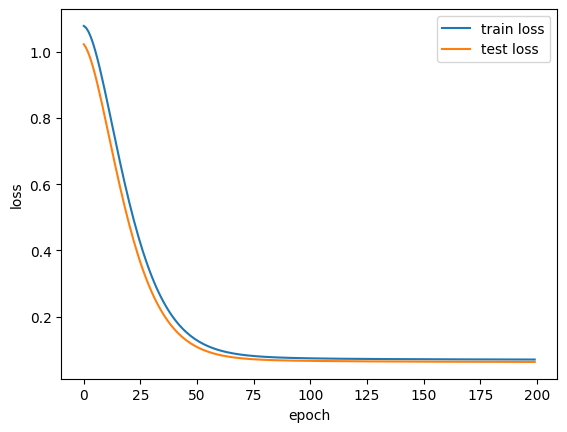

In [18]:
plt.plot(losses)
plt.plot(test_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'test loss'])

In [19]:
torch.save(model.state_dict(), 'weights/fenn.pt')

## Happiness Score model

In [33]:
wh_df = df.iloc[:, :12]
print(wh_df.isna().sum().sum())
wh_df_numeric= wh_df.drop(['Country', 'Country code', 'Year', 'Happiness rank'], axis=1)
wh_df_numeric.head()

0


,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,Generosity,Dystopia residual
0,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,0.365100,1.952100
1,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,0.312680,2.145580
2,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,0.311871,2.150801
3,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,0.191000,2.196000
4,4.959,0.878670,0.804340,0.813250,0.35733,0.064130,0.142720,1.898940


In [45]:
train, test = train_test_split(wh_df_numeric, test_size=0.1)
print(train.shape)
print(test.shape)

(411, 8)
(46, 8)


In [46]:
from sklearn.preprocessing import PolynomialFeatures
def transform(data):
    X_origin = data.drop('Happiness score', axis=1).to_numpy()
    poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly_transformer.fit_transform(X_origin)
    return X_poly, data['Happiness score'].to_numpy().reshape((-1, 1))

In [48]:
X_train, y_train = transform(train)
print(X_train.shape)
print(y_train.shape)

(411, 35)
(411, 1)


In [49]:
from sklearn.linear_model import LinearRegression

poly_model = LinearRegression()
poly_model.fit(X_train, y_train)

LinearRegression()

In [54]:
X_test, y_test = transform(test)
y_preds = poly_model.predict(X_test)

(46, 1)


In [57]:
from sklearn.metrics import mean_squared_error

mae = mean_squared_error(y_test, y_preds)
print(mae)

6.097828977077581e-08


## Urbanization indicators modeling

In [68]:
import pycountry
def get3countryCode(names):
    # Store the country codes that are found in a dictionary to speed up the function
    code_map = dict()
    
    res = []
    for name in names:
        try:
            try:
                code = code_map[name]
            except KeyError:
                code = pycountry.countries.search_fuzzy(name)[0].alpha_3
                code_map[name] = code
                
            res.append(code)
        except LookupError:
            res.append(None)
    
    return pd.Series(res)

In [70]:
developed_countries = pd.read_csv(f'./dataset/developed_countries.csv')
developed_countries['Country code'] = get3countryCode(developed_countries['Country'])

In [73]:
sgd = pd.read_csv('./dataset/world_happiness/sustainable_develop_goals/sdg-csv-zip-7-mb-/SDGData.csv')
sgd_urban = sgd[sgd['Indicator Name'].isin(
    URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS
)].iloc[:, :33]
print(sgd_urban.shape)
sgd_urban.head()

(5260, 33)


,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
18,Arab World,ARB,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,NaN,3.371729e+03,3.358098e+03,3.413832e+03,3.494529e+03,3.393017e+03,...,4.635513e+03,4.906752e+03,5.126634e+03,5.386084e+03,5.556237e+03,5.547096e+03,5.627784e+03,5.677982e+03,NaN,NaN
19,Arab World,ARB,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,1.753600e+03,1.562200e+03,1.970600e+03,2.225700e+03,2.637100e+03,2.924400e+03,...,1.455754e+04,1.579209e+04,1.713693e+04,1.971176e+04,2.223401e+04,2.469890e+04,2.591846e+04,2.786970e+04,3.024622e+04,NaN
20,Arab World,ARB,"Air transport, passengers carried",IS.AIR.PSGR,3.148400e+07,2.883510e+07,3.387710e+07,3.401740e+07,3.596830e+07,3.591820e+07,...,9.537205e+07,1.267965e+08,1.358376e+08,1.520142e+08,1.662093e+08,1.816273e+08,1.959570e+08,2.143187e+08,2.240003e+08,NaN
21,Arab World,ARB,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,Arab World,ARB,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.442000e+00,NaN,NaN,NaN


In [74]:
sgd_urban.isna().sum(axis=1)

18        3
19        1
20        1
21       29
23       28
         ..
98433     1
98437    29
98542    28
98543    29
98615     1
Length: 5260, dtype: int64

## Make some plots